In [ ]:
!rm -rf Driving-Data

In [1]:
!git clone https://github.com/oallam40/Driving-Data.git

fatal: destination path 'Driving-Data' already exists and is not an empty directory.


In [2]:
!ls Driving-Data

Data  driving_log.csv  IMG  README.md


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
%matplotlib inline

In [4]:
datadir = 'Driving-Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)

# Set the display option for pandas to show full contents of cells
pd.set_option('display.max_colwidth', -1)

# Display the first few rows of the data
data.head()

<ipython-input-4-374de194b520>:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\center_2024_02_18_18_24_58_263.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\left_2024_02_18_18_24_58_263.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\right_2024_02_18_18_24_58_263.jpg,0.0,0.000000,0.0,0.793703
1,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\center_2024_02_18_18_24_58_334.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\left_2024_02_18_18_24_58_334.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\right_2024_02_18_18_24_58_334.jpg,0.0,0.000000,0.0,0.788915
2,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\center_2024_02_18_18_24_58_404.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\left_2024_02_18_18_24_58_404.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\right_2024_02_18_18_24_58_404.jpg,0.0,0.000000,0.0,0.782576
3,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\center_2024_02_18_18_24_58_473.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\left_2024_02_18_18_24_58_473.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\right_2024_02_18_18_24_58_473.jpg,0.0,0.000000,0.0,0.777855
4,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\center_2024_02_18_18_24_58_545.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\left_2024_02_18_18_24_58_545.jpg,C:\Users\oalla\OneDrive\Desktop\Thesis_SiL\Data\IMG\right_2024_02_18_18_24_58_545.jpg,0.0,0.035618,0.0,0.783920


In [5]:
# Define a function to extract the leaf (i.e., the file name) from a file path, where
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

# Apply the path_leaf function to the 'center', 'left', and 'right' columns of the data to extract the file names
# By passing the path_leaf in every single value of our series and returning only the tail!
data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)

#Display the data Within the correct formate
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_02_18_18_24_58_263.jpg,left_2024_02_18_18_24_58_263.jpg,right_2024_02_18_18_24_58_263.jpg,0.0,0.000000,0.0,0.793703
1,center_2024_02_18_18_24_58_334.jpg,left_2024_02_18_18_24_58_334.jpg,right_2024_02_18_18_24_58_334.jpg,0.0,0.000000,0.0,0.788915
2,center_2024_02_18_18_24_58_404.jpg,left_2024_02_18_18_24_58_404.jpg,right_2024_02_18_18_24_58_404.jpg,0.0,0.000000,0.0,0.782576
3,center_2024_02_18_18_24_58_473.jpg,left_2024_02_18_18_24_58_473.jpg,right_2024_02_18_18_24_58_473.jpg,0.0,0.000000,0.0,0.777855
4,center_2024_02_18_18_24_58_545.jpg,left_2024_02_18_18_24_58_545.jpg,right_2024_02_18_18_24_58_545.jpg,0.0,0.035618,0.0,0.783920


Total number of Data: 7340


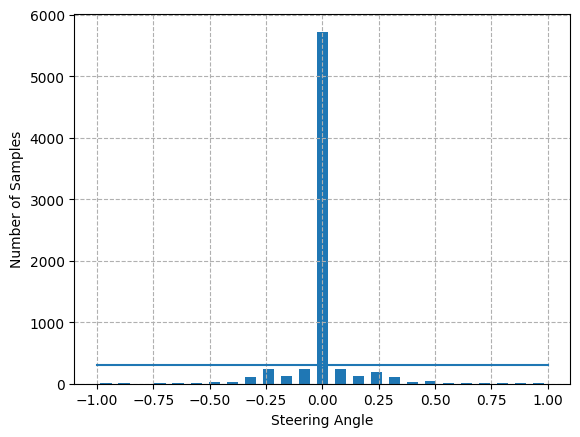

In [6]:
# Plotting this histogram of training data shows us that the data we obtained from driving in the track
# More zeros angles because of the nature of the track. The left and right steering angle seemed to be pretty balanced.
# If we train the model based on this data this creates a problem for the neural network.
# Which could bias the model towards predicting a zero angle. Thus the car becomes biased towards driving straight all the time.
# To improve this what we're going to do is reject all the samples above a certain threshold and
# Make the data more uniform and not biased towards a specific steering angle.

# Number of bins for the histogram of steering angles
num_bins = 25
samples_per_bin = 300
# Calculate the histogram of steering angles
hist, bins = np.histogram(data['steering'], num_bins)

# Calculate the center of each bin
center = (bins[:-1] +bins[1:]) * 0.5

# Plot a bar chart of the histogram
plt.bar(center, hist, width=0.05)

# Plot a line indicating the target number of samples per bin
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.xlabel('Steering Angle')  # Label for the x-axis
plt.ylabel('Number of Samples')  # Label for the y-axis
plt.grid(linestyle='--')
# print(bins)
print('Total number of Data:', len(data))

# what's under the line now represents what would be a uniform distribution of our data samples. So if we were to reject all samples that exceed 200.
# to avoid the data being more bias towards a zero steering angle

In [7]:
# shows the total number of data samples
print('total data:', len(data))

# Initialize an empty list to store the indices of the rows to be removed from the data
remove_list = []

# Loop through each bin of the histogram
for j in range(num_bins):
  list_ = []  # Initialize an empty list to store the indices of the rows in the current bin
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

total data: 7340


Number of rows removed: 5423
number of rows remaining: 1917


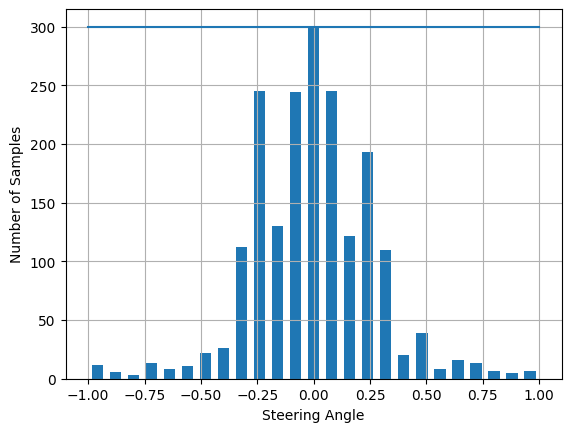

In [8]:
# The output is a distribution of steering angles that are much more uniform view data in relative proportion.
# There are significant left steering angles and significant right steering angles eliminating the extreme bias to driving straight all the time which would be problematic
print('Number of rows removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('number of rows remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.xlabel('Steering Angle')  # Label for the x-axis
plt.ylabel('Number of Samples')  # Label for the y-axis
plt.grid()

In [9]:
# Print the first row of the data
print(data.iloc[1])
# from the row of data, we want to access the center left and right images.

# Function to load the images and steering angle data
def load_img_steering(datadir, df):
  # Initialize empty lists to store the image paths and steering angles
  image_path = []
  steering = []

  for i in range(len(data)):
    indexed_data = data.iloc[i]

    # Get the file paths for the center, left, and right images
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

  #convert list into arrays
  image_paths = np.array(image_path)
  steerings = np.array(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir +'/IMG', data)
# So now we have to arrays
# One array for the images & in another array the crossponding label of this image (the steering angle)


center      center_2024_02_18_18_24_59_499.jpg
left        left_2024_02_18_18_24_59_499.jpg  
right       right_2024_02_18_18_24_59_499.jpg 
steering    0.0                               
throttle    1.0                               
reverse     0.0                               
speed       9.975833                          
Name: 17, dtype: object


In [10]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

# showing the number of samples in the training and validation sets
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1533
Valid Samples: 384


Text(0.5, 1.0, 'Validation set')

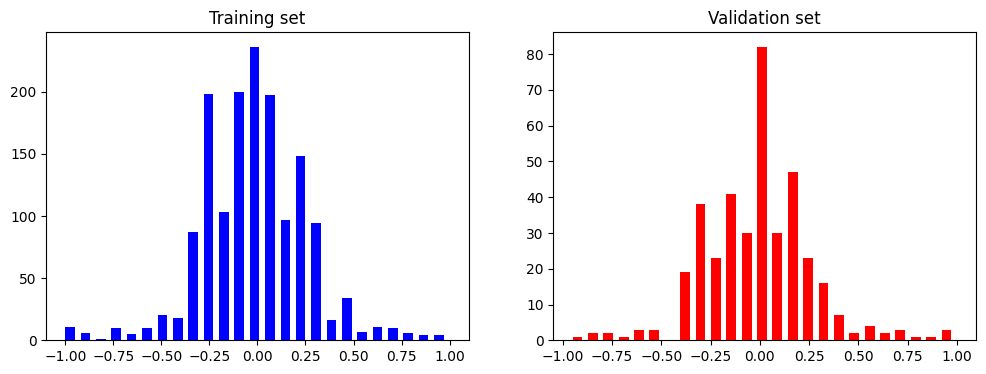

In [11]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram of steering angles for the training set on the first subplot
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')

# Plot the histogram of steering angles for the validation set on the second subplot
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [12]:
def img_preprocessing(img):
  img = mpimg.imread(img)
  return img

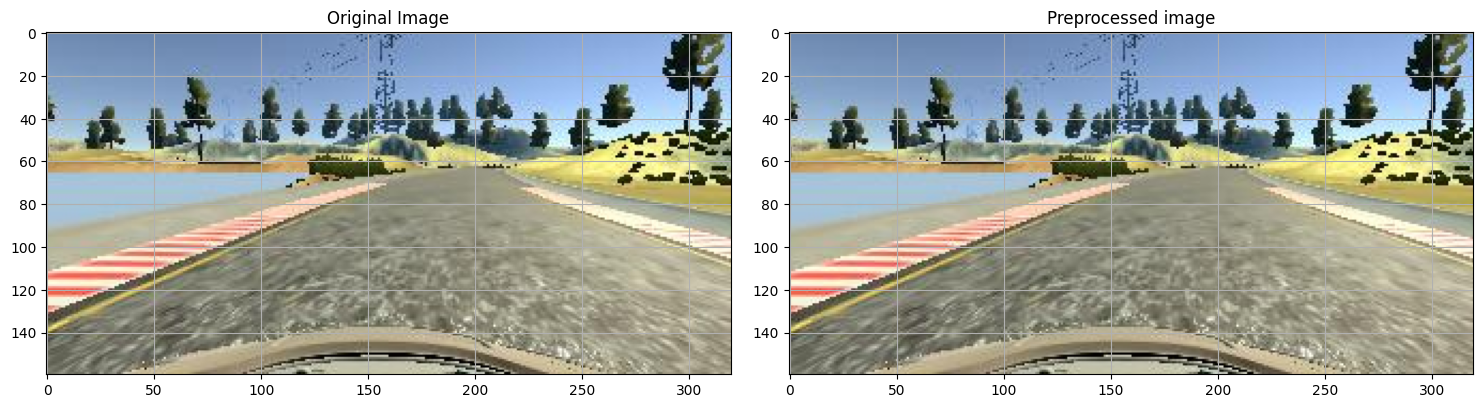

In [13]:
# Select an image file path
image = image_paths[100]

# Read the image and store it in a NumPy array
original_image = mpimg.imread(image)

# Preprocess the image
preprocessed_image = img_preprocessing(image)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[0].grid()

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')
axs[1].grid()

In [14]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img= cv2.resize(img, (200, 66))
  img = img/255
  return img

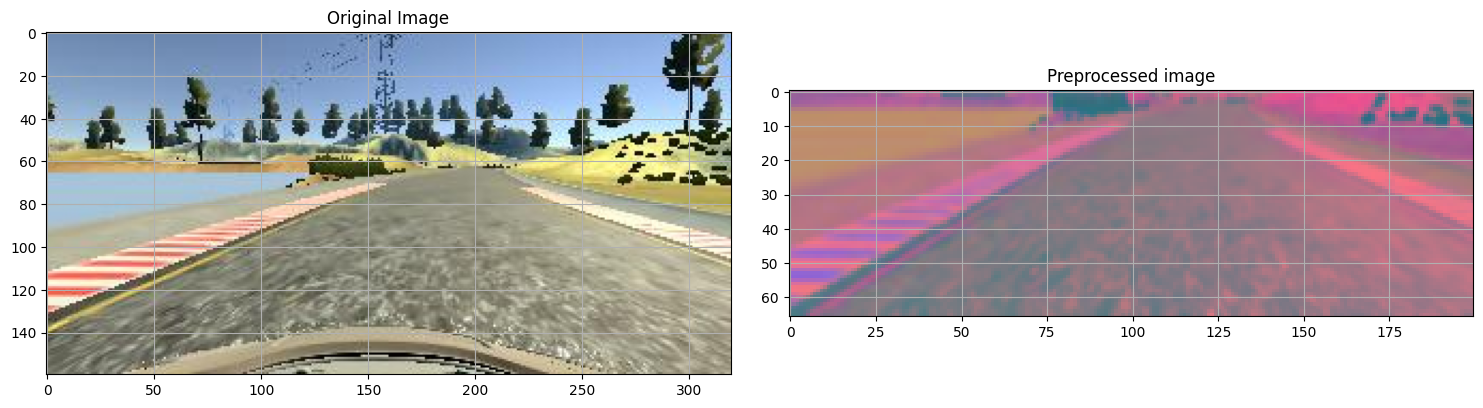

In [15]:
# Select an image file path
image = image_paths[100]

# Read the image and store it in a NumPy array
original_image = mpimg.imread(image)

# Preprocess the image
preprocessed_image = img_preprocess(image)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[0].grid()

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')
axs[1].grid()

In [16]:
X_train = np.array(list(map(img_preprocess, X_train,)))
X_valid = np.array(list(map(img_preprocess, X_valid,)))

Shape:  (1533, 66, 200, 3)


(-0.5, 199.5, 65.5, -0.5)

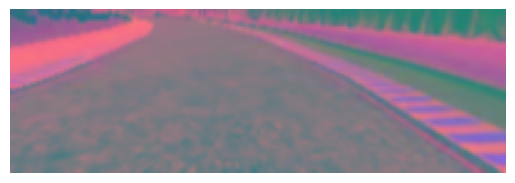

In [17]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print('Shape: ',X_train.shape)
plt.axis('off')

In [18]:
def nvidia_model():
  # Create a Sequential model
  model = Sequential()

  # 1. Add a convolutional layer with 24 filters, 5x5 kernel size, 2x2 stride, and ReLU activation
  # 2. Add a convolutional layer with 36 filters, 5x5 kernel size, 2x2 stride, and ReLU activation
  # 3. Add a convolutional layer with 48 filters, 5x5 kernel size, 2x2 stride, and ReLU activation
  # 4. Add a convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
  # 5. Add a convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
  ### Note That ###
  # Architecture shows just that the last 2 layers are identical. They both have 64 filters with (3,3) kernel size instead of (5,5) that we've been using and due all of the convolutions
  # that our image has already gone through at this point its dimensions have decreased significantly. For this reason we are going to remove the subsampling in our 4th,5th layers


  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))


  # Add a dropout layer with a rate of 0.5
  # It means that within each of these layers randomly turn 50 percent of their inputs they receive to 0
  model.add(Dropout(0.5))

  # Flatten the output of the convolutional layers
  model.add(Flatten())

  # Add a dense layer with 100 units and eLU activation
  # Add a dropout layer with a rate of 0.5
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  # Add a dense layer with 50 units and eLU activation
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  # Add a dense layer with 10 units and eLU activation
  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))


  # Add a dense layer with 1 unit (output layer)
  model.add(Dense(1))

  # Create an Adam optimizer with a learning rate of 1e-3
  optimizer = Adam(lr=1e-3)

  # Compile the model with a mean squared error loss function and the Adam optimizer
  model.compile(loss='mse', optimizer=optimizer)

  # Return the model
  return model

In [19]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [20]:
history = model.fit(X_train, y_train, epochs=30, validation_data = (X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
16/16 [==============================] - 14s 685ms/step - loss: 0.2592 - val_loss: 0.0626
Epoch 2/30
16/16 [==============================] - 10s 650ms/step - loss: 0.0953 - val_loss: 0.0606
Epoch 3/30
16/16 [==============================] - 10s 645ms/step - loss: 0.0802 - val_loss: 0.0574
Epoch 4/30
16/16 [==============================] - 11s 694ms/step - loss: 0.0685 - val_loss: 0.0541
Epoch 5/30
16/16 [==============================] - 10s 621ms/step - loss: 0.0664 - val_loss: 0.0496
Epoch 6/30
16/16 [==============================] - 11s 667ms/step - loss: 0.0660 - val_loss: 0.0496
Epoch 7/30
16/16 [==============================] - 10s 637ms/step - loss: 0.0594 - val_loss: 0.0531
Epoch 8/30
16/16 [==============================] - 11s 692ms/step - loss: 0.0633 - val_loss: 0.0489
Epoch 9/30
16/16 [==============================] - 10s 650ms/step - loss: 0.0580 - val_loss: 0.0473
Epoch 10/30
16/16 [==============================] - 10s 603ms/step - loss: 0.0571 - val_lo

Text(0.5, 0, 'Epoch')

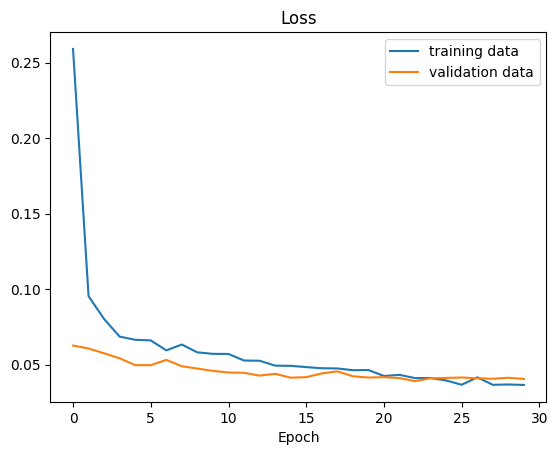

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training data', 'validation data'])
plt.title('Loss')
plt.xlabel('Epoch')